- 代码：

链接：https://pan.baidu.com/s/1H4k530XujXovqsi-yXZlmA 
提取码：lpba

- 视频：
1. https://www.bilibili.com/video/BV1ZV4y1X7BM/?spm_id_from=333.999.0.0&vd_source=bca0a3605754a98491958094024e5fe3

1. https://www.bilibili.com/video/BV1b541197HX/?spm_id_from=333.999.0.0&vd_source=bca0a3605754a98491958094024e5fe3

shape of s: (10000, 2)


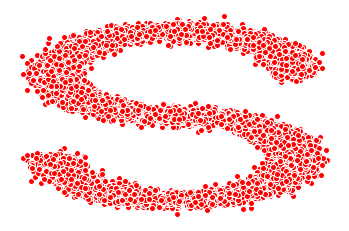

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve,_ = make_s_curve(10**4,noise=0.1) # 样本数为10000，噪声为0.1
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='red',edgecolor='white');

ax.axis('off')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torch.Tensor(s_curve).float().to(device)

In [2]:
dataset[0]

tensor([-0.0617,  0.1924], device='cuda:0')

2、确定超参数的值

In [3]:
num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps).to(device)
#步长由sigmoid生成，算法本身可以选取多种步长变化策略
betas = (torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5).to(device)

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas

# prod就是累乘，就是论文里面带杠杠的哪个
alphas_prod = torch.cumprod(alphas,0).to(device)
# 第一项换成1
alphas_prod_p = (torch.cat([torch.ones(1).to(device),alphas_prod[:-1]],0)).to(device)

# 开根号
alphas_bar_sqrt = torch.sqrt(alphas_prod).to(device)

# log(1 - α)和sqrt(1 - α) 
one_minus_alphas_bar_log = torch.log(1 - alphas_prod).to(device)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod).to(device)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


3、确定扩散过程任意时刻的采样值

![扩散](diffusion.png)

In [4]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0).to(device)

    # 取出均值
    alphas_t = alphas_bar_sqrt[t]
    # 取出标准差
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]

    # 参数重整化技巧
    return (alphas_t * x_0 + alphas_1_m_t * noise)#在x[0]的基础上添加噪声
    

4、演示原始数据分布加噪100步后的结果

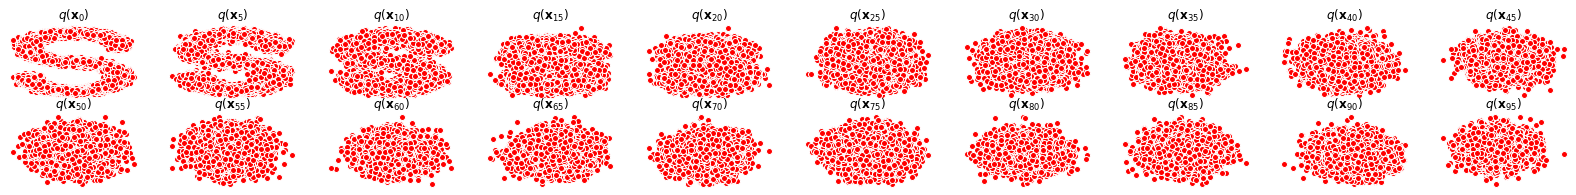

In [5]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]).to(device)).cpu().detach()#生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

5、编写拟合逆扩散过程高斯分布的模型

In [6]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
#         x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x

6、编写训练的误差函数

![损失函数](diffusion_loss.png)

In [7]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t
    t = torch.randint(0,n_steps,size=(batch_size//2,)).to(device)
    t = torch.cat([t,n_steps-1-t],dim=0).to(device)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音eps
    e = torch.randn_like(x_0).to(device)
    
    #构造模型的输入
    x = x_0*a+e*aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1))
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

7、逆向扩散，即推理过程。编写逆扩散采样函数（inference）

![](inverse_diffusion.png)

In [8]:
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[t]"""
    t = torch.tensor([t]).to(x.device)
    
    # 模型给出的噪声前面的那个系数
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    # 模型预测噪声
    eps_theta = model(x,t)
    
    # 恢复均值
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    # 从噪声中拿到的方差是已知的
    sigma_t = betas[t].sqrt()

    # 恢复
    sample = mean + sigma_t * z
    
    return (sample)

def p_sample_loop(model,shape,betas,one_minus_alphas_bar_sqrt,n_steps):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

8、开始训练模型，打印loss及中间重构效果

========Training model...========
Epoch: 0, Loss: 0.43807506561279297
Epoch: 100, Loss: 0.34807491302490234
Epoch: 200, Loss: 0.2760496735572815
Epoch: 300, Loss: 0.24287930130958557
Epoch: 400, Loss: 0.3195468783378601
Epoch: 500, Loss: 0.23153367638587952
Epoch: 600, Loss: 0.33789724111557007
Epoch: 700, Loss: 0.5746204853057861
Epoch: 800, Loss: 0.190040722489357
Epoch: 900, Loss: 0.26973187923431396
Epoch: 1000, Loss: 0.6574207544326782
Epoch: 1100, Loss: 0.27509286999702454
Epoch: 1200, Loss: 0.35202252864837646
Epoch: 1300, Loss: 0.5972674489021301
Epoch: 1400, Loss: 0.23028700053691864
Epoch: 1500, Loss: 0.45084622502326965
Epoch: 1600, Loss: 0.2644326388835907
Epoch: 1700, Loss: 0.2875547707080841
Epoch: 1800, Loss: 0.27084967494010925
Epoch: 1900, Loss: 0.24008655548095703
Epoch: 2000, Loss: 0.3067299425601959


<ipython-input-9-415e46a35934>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


Epoch: 2100, Loss: 0.3727295696735382
Epoch: 2200, Loss: 0.4479081928730011
Epoch: 2300, Loss: 0.22098463773727417
Epoch: 2400, Loss: 0.3029415011405945
Epoch: 2500, Loss: 0.2945634722709656
Epoch: 2600, Loss: 0.16092509031295776
Epoch: 2700, Loss: 0.3056601583957672
Epoch: 2800, Loss: 0.4754883050918579
Epoch: 2900, Loss: 0.5661584734916687
Epoch: 3000, Loss: 0.1368992030620575
Epoch: 3100, Loss: 0.18080449104309082
Epoch: 3200, Loss: 0.1560363918542862
Epoch: 3300, Loss: 0.19471246004104614
Epoch: 3400, Loss: 0.22825393080711365
Epoch: 3500, Loss: 0.2823353409767151
Epoch: 3600, Loss: 0.2914780080318451
Epoch: 3700, Loss: 0.3080677390098572
Epoch: 3800, Loss: 0.28788015246391296
Epoch: 3900, Loss: 0.3554885983467102


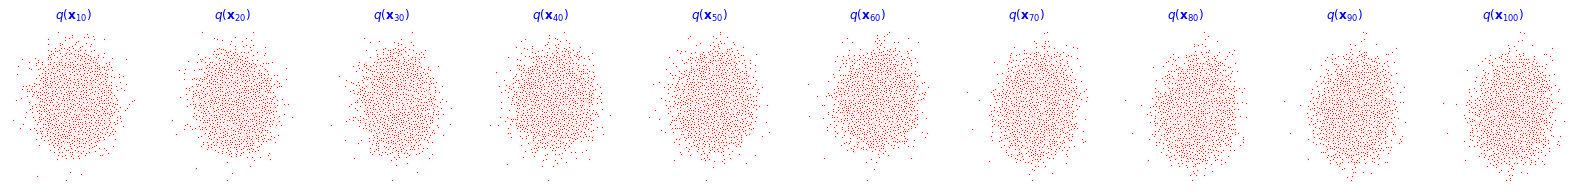

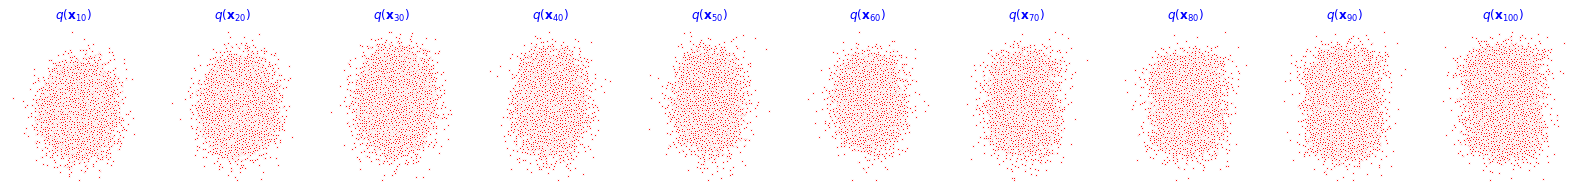

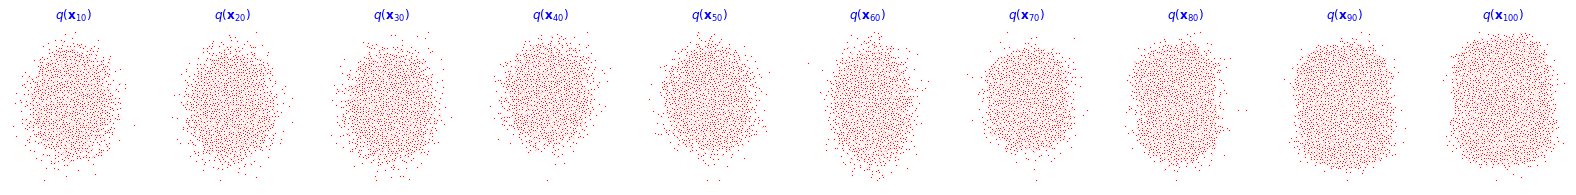

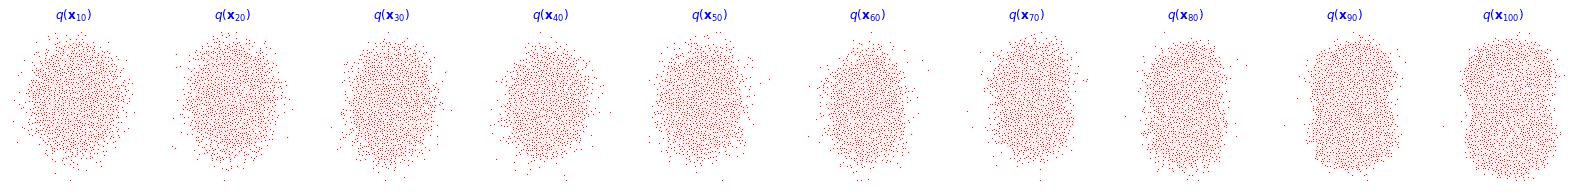

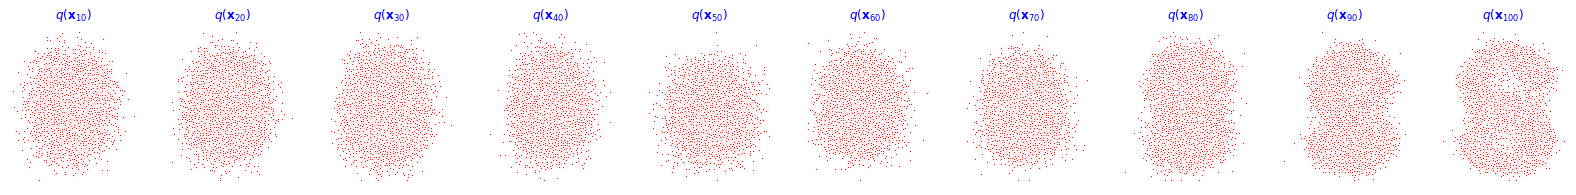

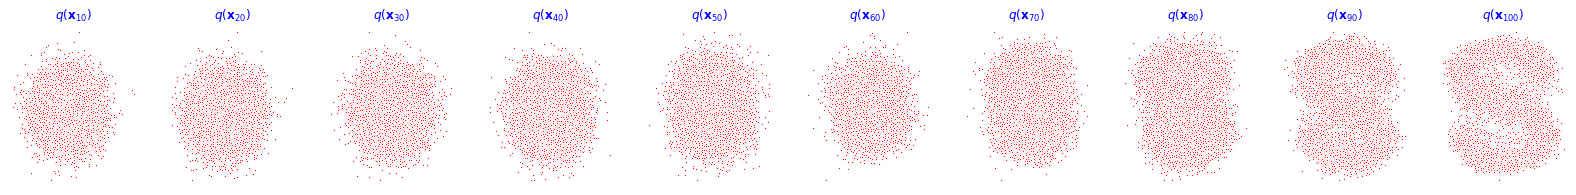

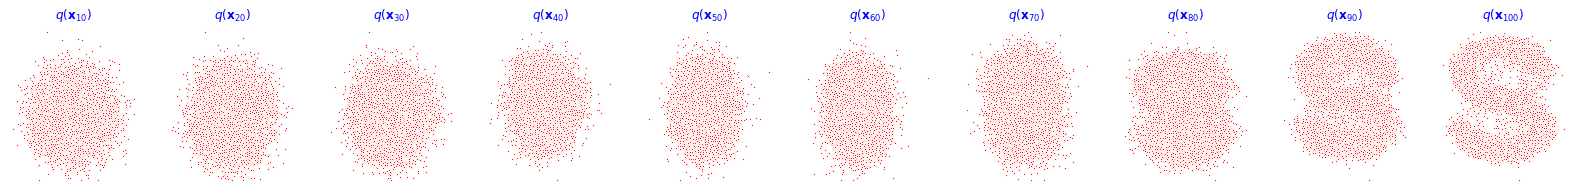

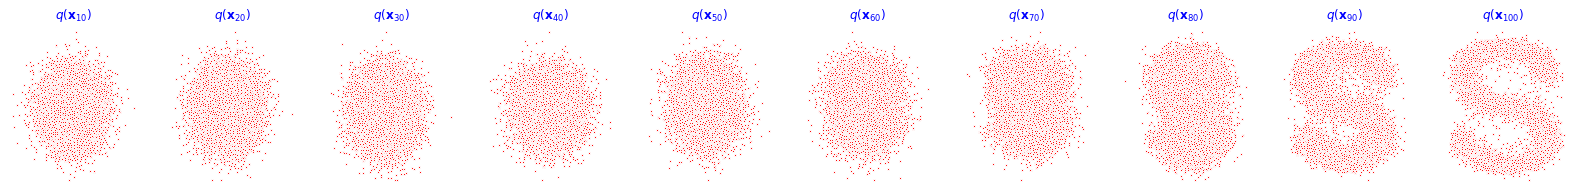

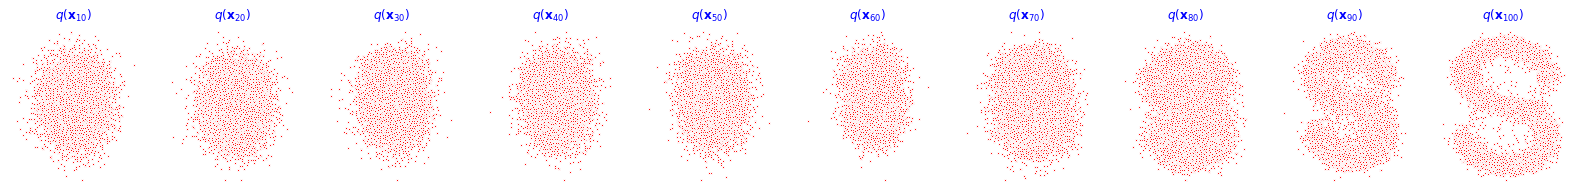

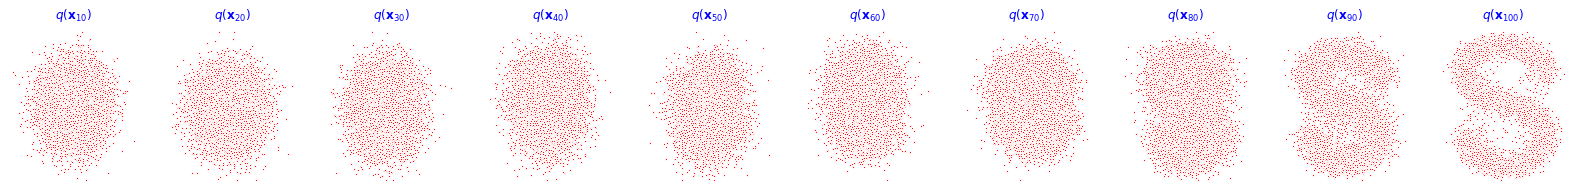

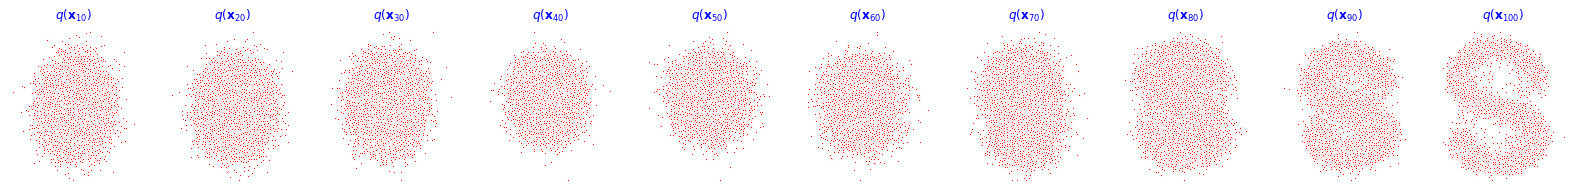

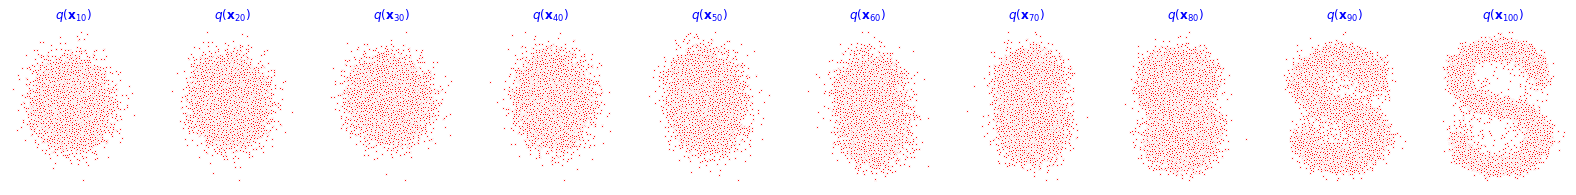

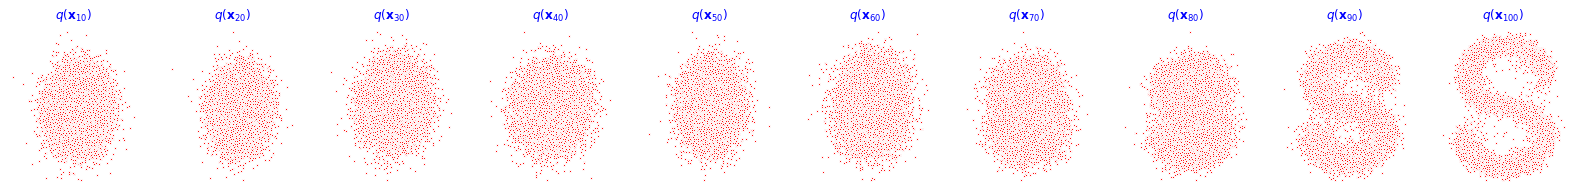

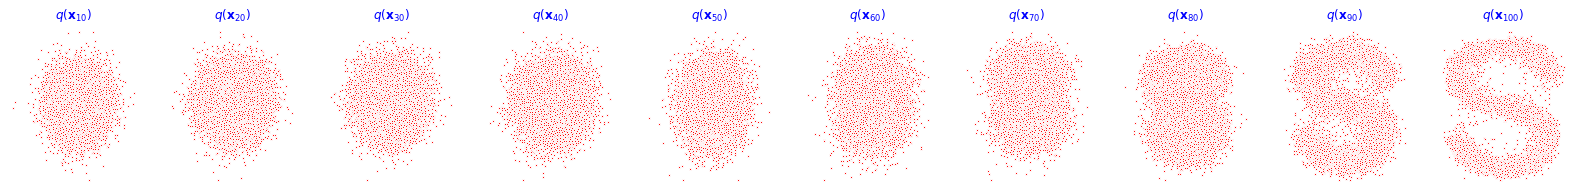

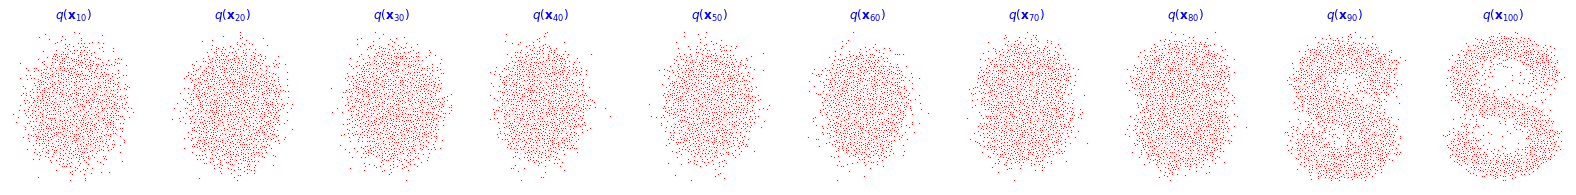

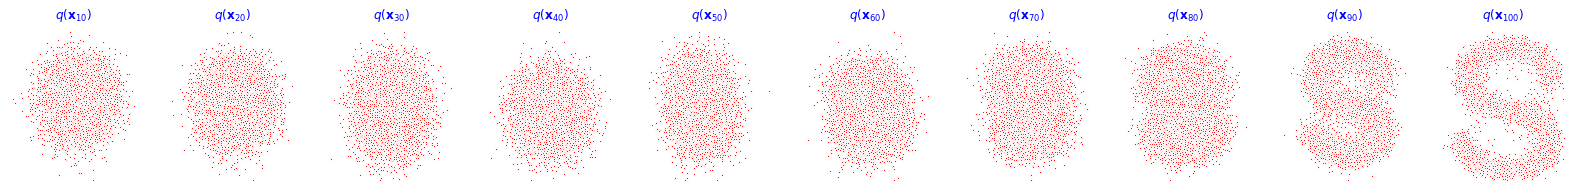

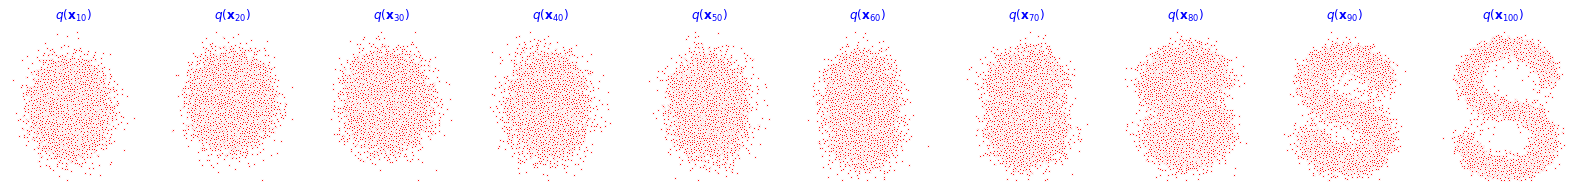

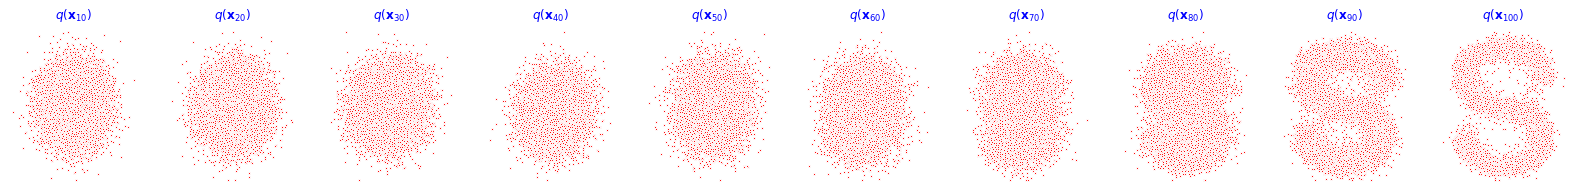

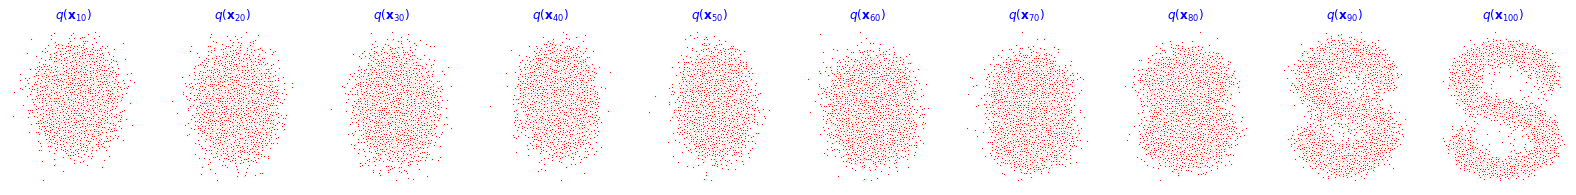

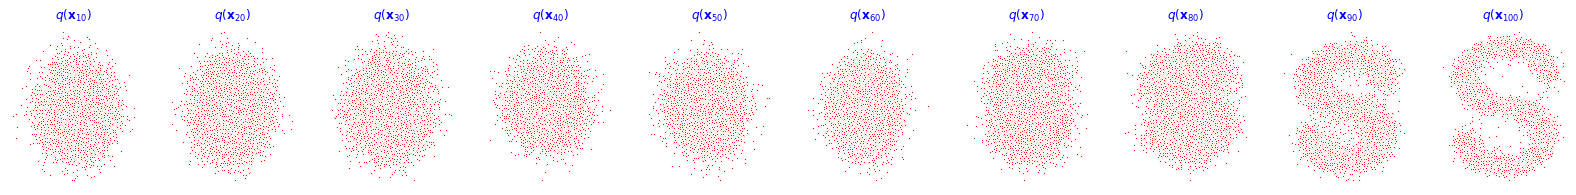

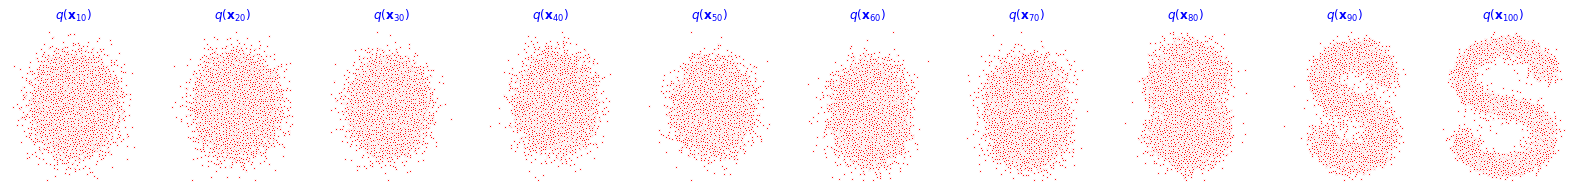

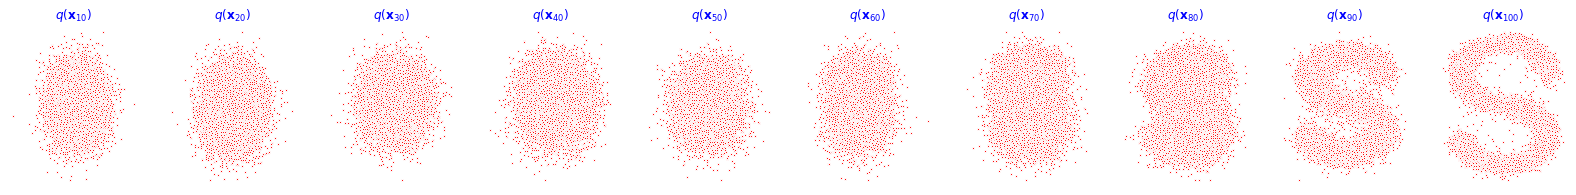

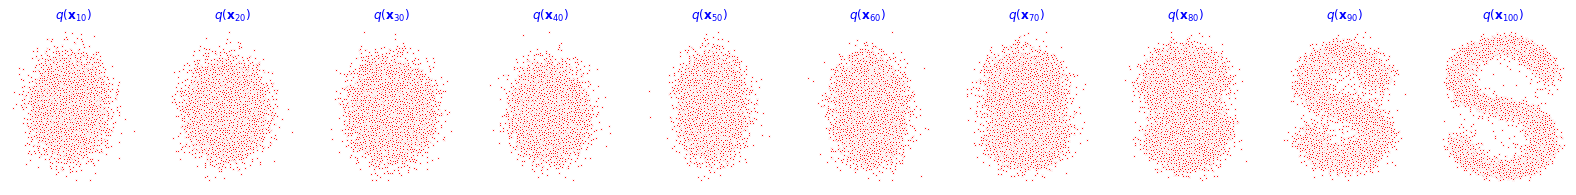

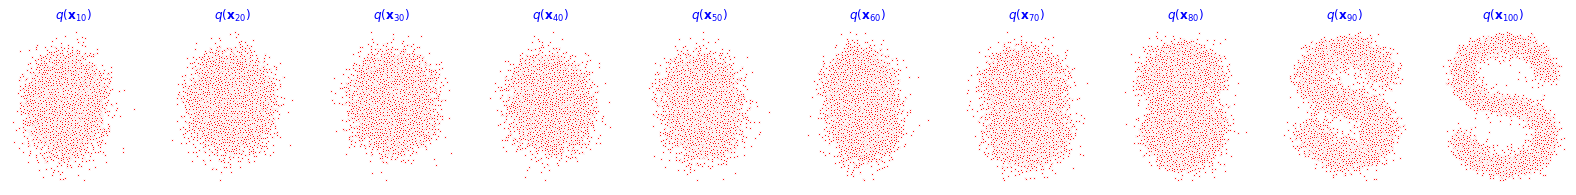

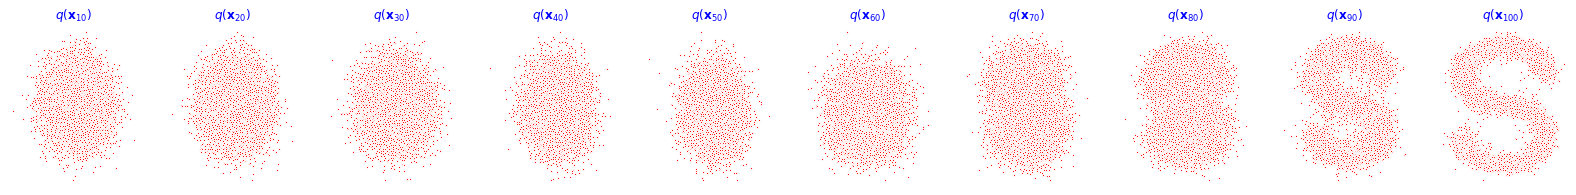

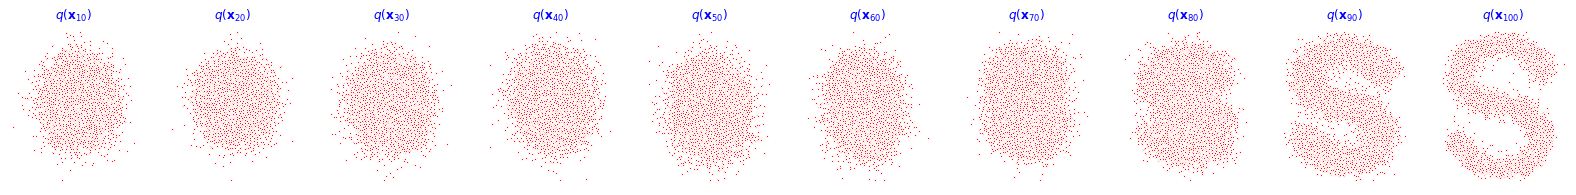

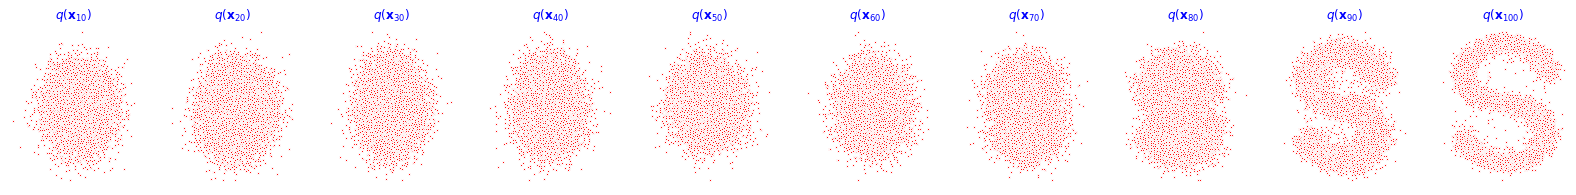

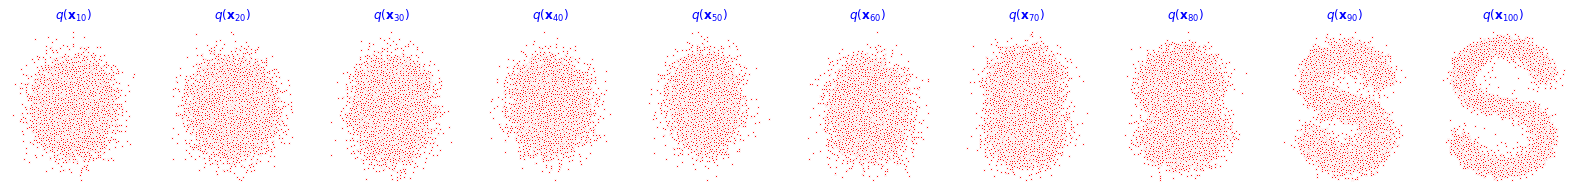

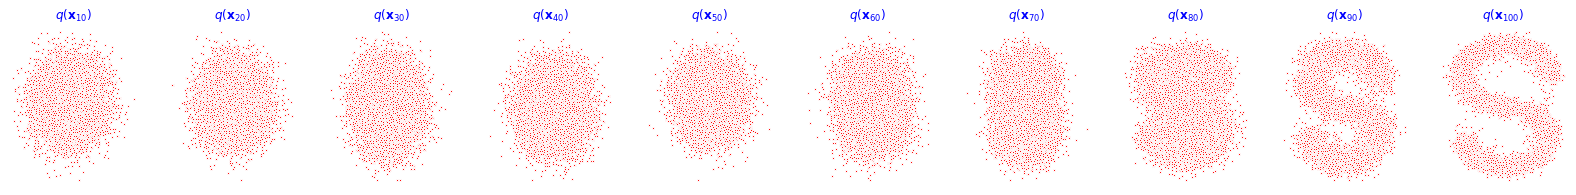

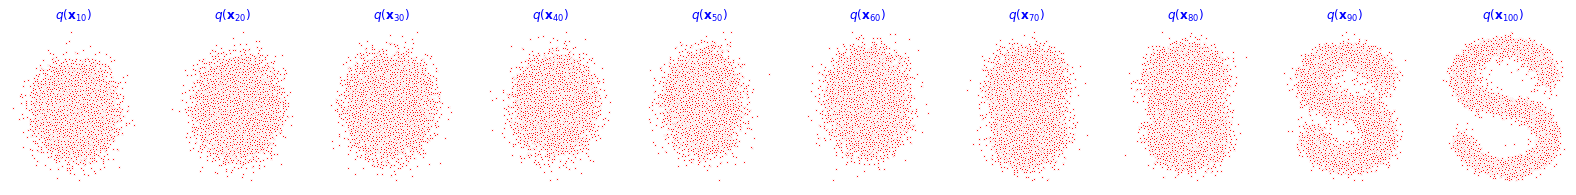

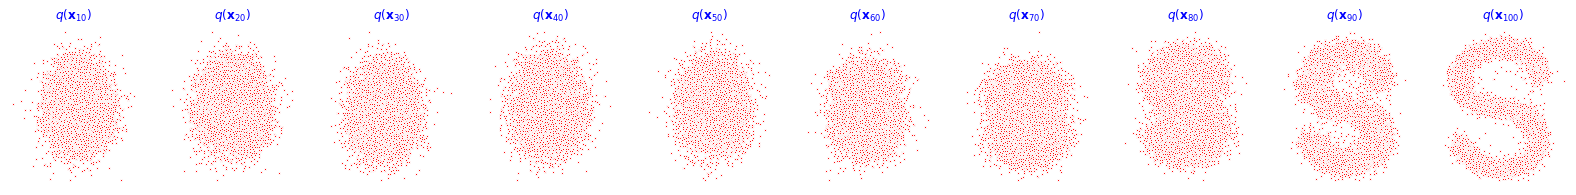

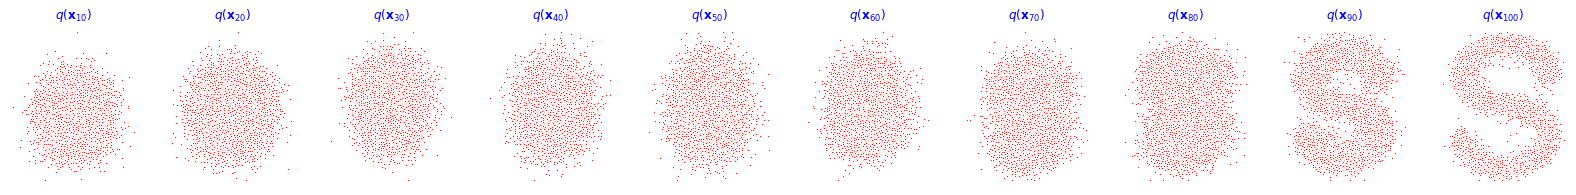

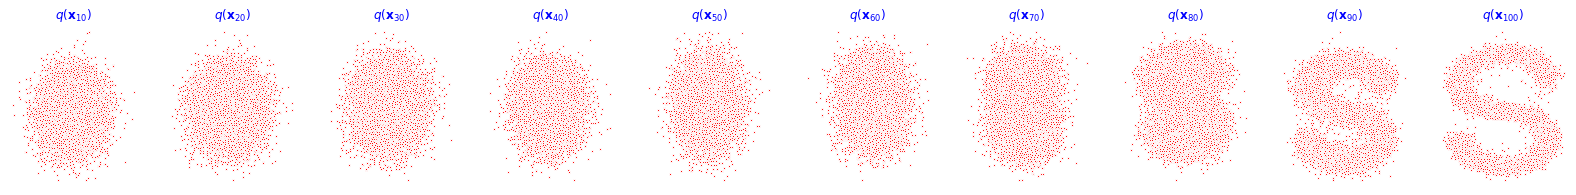

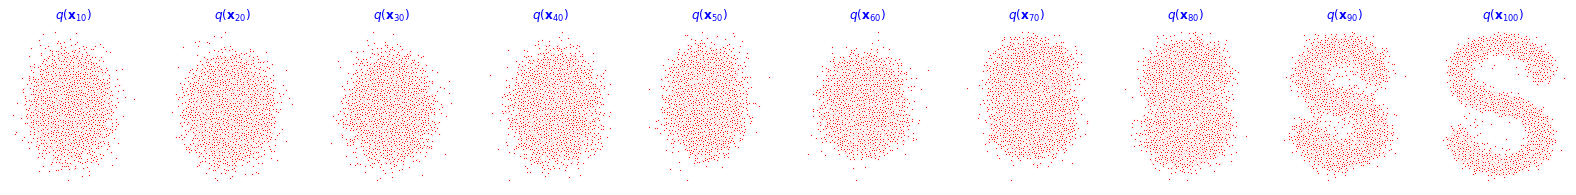

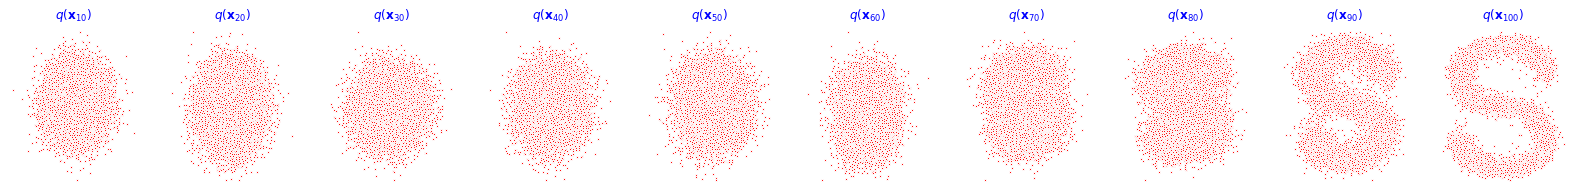

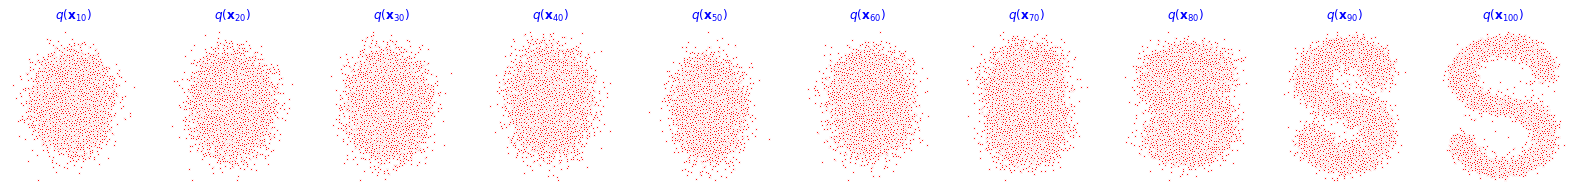

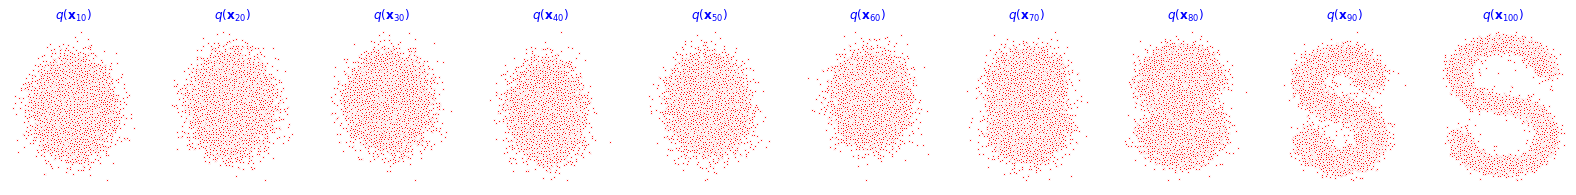

In [9]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('========Training model...========')

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x.to(device),alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(f"Epoch: {t}, Loss: {loss.item()}")
        x_seq = p_sample_loop(model,dataset.shape,betas,one_minus_alphas_bar_sqrt,num_steps)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach().cpu()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

9、动画演示扩散过程和逆扩散过程

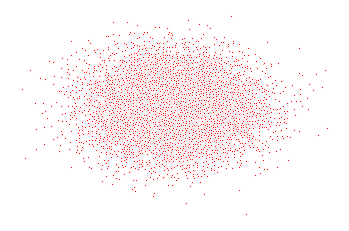

In [10]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]).to(device)).cpu().detach()
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

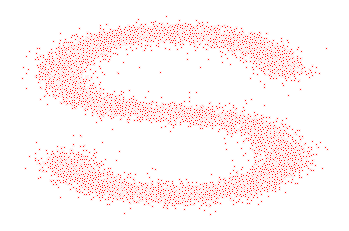

In [11]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach().cpu()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [12]:
imgs = imgs + reverse

In [13]:
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

![GIF](diffusion.gif)